Laboratorio 3

Práctica 2

Autores: 

Raúl Jiménez Juárez 

Beatriz Magán Pinto 

David Alonso Rodríguez Lepina 

Andrés Felipe Sánchez Patarroyo 
         
Asignatura: Aprendizaje estadístico & Data Mining    

Fecha: 31 de octubre de 2019

Objetivo: 
La ciudad de San Francisco es famosa entre otras cosas por la proliferación de empresas del ámbito tecnológico. Esto ha llevado a una profunda desigualdad entre sus habitantes, por lo que la proliferación de crímenes ha aumentado. Es por ello qué se quiere construir un clasificador que proporcione una serie de reglas de manera que se pueda saber que crímenes se van a cometer teniendo en cuenta el momento del día (noche de 0:00 a 7:59, mañana de 8:00 a 15:59 y tarde de 16:00 a 23:59), día de la semana y distrito.

# Importamos las librerías necesarias

In [1]:
import numpy as np 
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import matplotlib as mp
from sklearn.model_selection import train_test_split
from datetime import datetime, time
from sklearn.model_selection  import cross_val_score 
from enum import Enum
import numpy as np
from sklearn import tree
from subprocess import check_call
from IPython.display import Image as PImage
import matplotlib.pyplot as plt
import os
import pydot

## Preprocesamiento de datos

In [2]:
#Importamos los datos y los preprocesamos:
df_crimenes = pd.read_csv("Recursos_Lab_3/sf_crimenes.csv")
#Eliminamos del dataframe las filas que sean NA (Not available)
df_crimenes = df_crimenes.dropna()

#Guardamos en la variable crime_time los momentos del día en que han sucedido los crímenes.
crime_time = [df_crimenes["Dates"].loc[i].split(" ")[1] for i in range(len(df_crimenes))]
etiqueta_momento = []
for i in range(len(crime_time)):
    #Seleccionamos la hora de la variable crime_time.
    hora = time(datetime.strptime(crime_time[i], '%H:%M').hour, datetime.strptime(crime_time[i], '%H:%M').minute)
    #Definimos si es noche, mañana o tarde según la hora obtenida.
    if hora >= time(0, 0)  and hora < time(8, 0):
        etiqueta_momento.append('Noche')
    elif hora >= time(8, 0)  and hora < time(16, 0):
        etiqueta_momento.append('Mañana')
    else:
        etiqueta_momento.append('Tarde')

#Guardamos las etiquetas noche, mañana y tarde en la columna "Dates" del dataframe. 
df_crimenes["Dates"] = etiqueta_momento

In [3]:
#Guardamos en tres diccionarios distintos, los valores únicos de las columnas DayOfWeek, PdDistrict, Dates y Category.
dias_de_la_semana = {"DayOfWeek": df_crimenes["DayOfWeek"].unique(), 
                     "Value"    : np.arange(0, len(df_crimenes["DayOfWeek"].unique()))}

distritos = { "PdDistrict": df_crimenes["PdDistrict"].unique(),
              "Value"     : np.arange(0, len(df_crimenes["PdDistrict"].unique()))}

momento_dia = {"Dates" : df_crimenes["Dates"].unique(),
               "Value" : np.arange(0, len(df_crimenes["Dates"].unique()))}

categoria = {"Category": df_crimenes["Category"].unique(),
             "Value"   : np.arange(0, len(df_crimenes["Category"].unique()))}

#Para cada elemento le asignamos un valor numérico para facilitar el posterior tratamiento de los datos.
for i in range(len(dias_de_la_semana["Value"])):
    df_crimenes["DayOfWeek"] = df_crimenes["DayOfWeek"].replace(dias_de_la_semana["DayOfWeek"][i], str(dias_de_la_semana["Value"][i]))

for i in range(len(distritos["Value"])):
    df_crimenes["PdDistrict"] = df_crimenes["PdDistrict"].replace(distritos["PdDistrict"][i], str(distritos["Value"][i]))

for i in range(len(momento_dia["Value"])):
    df_crimenes["Dates"] = df_crimenes["Dates"].replace(momento_dia["Dates"][i], str(momento_dia["Value"][i]))

for i in range(len(categoria["Value"])):
    df_crimenes["Category"] = df_crimenes["Category"].replace(categoria["Category"][i], str(categoria["Value"][i]))
    
#Casteamos los valores de las columnas de día de la semana, distrito, fechas y categoría como tipo entero para que no haya problemas
#de incompatibilidad de tipos de variables.
df_crimenes["DayOfWeek"] = df_crimenes["DayOfWeek"].astype(int)
df_crimenes["PdDistrict"] = df_crimenes["PdDistrict"].astype(int)
df_crimenes["Dates"] = df_crimenes["Dates"].astype(int)
df_crimenes["Category"] = df_crimenes["Category"].astype(int)

In [4]:
#Definimos los conjuntos de entrenamiento y de validación explicando que el 20% de los datos serán de validación. 
train, test = train_test_split(df_crimenes, test_size=0.2)

#La entrada (x_train) guardará las columnas de día de la semana, distrito y momento del día que serán necesarias para el entrenamiento.
x_train = train[["DayOfWeek", "PdDistrict", "Dates"]]
#La salida (y_train) será la etiqueta del delito, su categoría, es decir, su tipo. 
y_train = train["Category"]

x_test = test[["DayOfWeek", "PdDistrict", "Dates"]]
y_test = test["Category"]

## 1º Selección de clasificador que más se adapte a nuestro problema de entre los vistos en clase. 
Usamos scikit-learn.

Para este ejercicio hemos decidido utilizar árboles de decisión para crear reglas que permitan clasificar el crimen según el momento del día, el día de la semana y el distrito, por lo que seleccionamos estas tres variables y obtendremos el tipo de crimen.

## 2º Creamos un clasificador en el que usamos al menos dos criterios de división distintos. 

Hemos seleccionado el clasificador de árbol de decisión con el objetivo de obtener las reglas de nuestro problema. 
Un árbol de decisión es un mapa de los posibles resultados de una serie de decisiones relacionadas. Permite comparar posibles acciones. Un árbol de decisión, por lo general, comienza con un único nodo y luego se ramifica en resultados posibles. Cada uno de esos resultados crea nodos adicionales, que se ramifican en otras posibilidades. Esto le da una forma similar a la de un árbol.
Los tres criterios de división seleccionados son: momento del día (mañana, tarde, noche), día de la semana y distrito, con el objetivo de obtener la clasificación de los crímenes. 

In [5]:
#Definimos el rango de profundidad desde 1 hasta el número total de categorías +1 para no empezar desde cero y facilitar asi su comprensión.
depth_range = range(1, len(categoria["Value"]) + 1)
accuracies =list()

for depth in depth_range:
    #Definomps el árbol de decisión siguiendo el criterio de entropía.
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                                 min_samples_split=20,
                                                 min_samples_leaf=5,
                                                 max_depth = depth,
                                                 class_weight={})

    fold_accuracy = []
    model = tree_model.fit(X = x_train,
                           y = y_train) 
    valid_acc = model.score(X = x_test, 
                            y = y_test) #Calculamos la precision con el segmento de validacion
    fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
#Mostramos los resultados obtenidos
df_arbol = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df_arbol = df_arbol[["Max Depth", "Average Accuracy"]]
print(df_arbol.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.281667
         2          0.273333
         3          0.285000
         4          0.281667
         5          0.276667
         6          0.256667
         7          0.263333
         8          0.251667
         9          0.250000
        10          0.245000
        11          0.238333
        12          0.243333
        13          0.243333
        14          0.243333
        15          0.243333
        16          0.243333
        17          0.243333
        18          0.243333
        19          0.243333
        20          0.243333
        21          0.243333
        22          0.243333
        23          0.243333
        24          0.243333
        25          0.243333
        26          0.243333
        27          0.243333
        28          0.243333
        29          0.243333
        30          0.243333
        31          0.243333


In [6]:
#Implementamos el árbol de decisión.
#Creamos Arbol de decision con profundidad = 3
#Criterio: entropy
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 3,
                                            class_weight={})
#Entrenamos el arbol de decisión. 
decision_tree.fit(x_train, y_train)
 
#Exportamos el modelo a archivo .dot
with open("tree-entropy.dot", 'w') as f:
    f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = ["DayOfWeek", "PdDistrict", "Dates"],
                              class_names = categoria["Category"][:],
                              rounded = True,
                              filled= True )
    
#Calculamos el error en cada uno de ellos y elegimos el que mejor clasifique.
error = 100 - decision_tree.score(x_test, y_test) * 100
print("El error obtenido es: ", error)

El error obtenido es:  71.5


In [7]:
#Crear Arbol de decision con profundidad = 3
#Critero: gini
decision_tree = tree.DecisionTreeClassifier(criterion='gini',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 3,
                                            class_weight={})
decision_tree.fit(x_train, y_train)
 
#Exportamos el modelo a archivo .dot
with open("tree-gini.dot", 'w') as f:
    f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 7,
                              impurity = True,
                              feature_names = ["DayOfWeek", "PdDistrict", "Dates"],
                              class_names = categoria["Category"][:],
                              rounded = True,
                              filled= True)
    
#Calculamos el error en cada uno de ellos y elegimos el que mejor clasifique.
error = 100 - decision_tree.score(x_test, y_test) * 100
print("El error obtenido es: ", error)

El error obtenido es:  72.0


### Por tanto, elegimos el clasificador con menor error, que es, el clasificador que sigue el criterio del índice GINI. 

## 3º Dibujamos el modelo elegido en el punto anterior. 

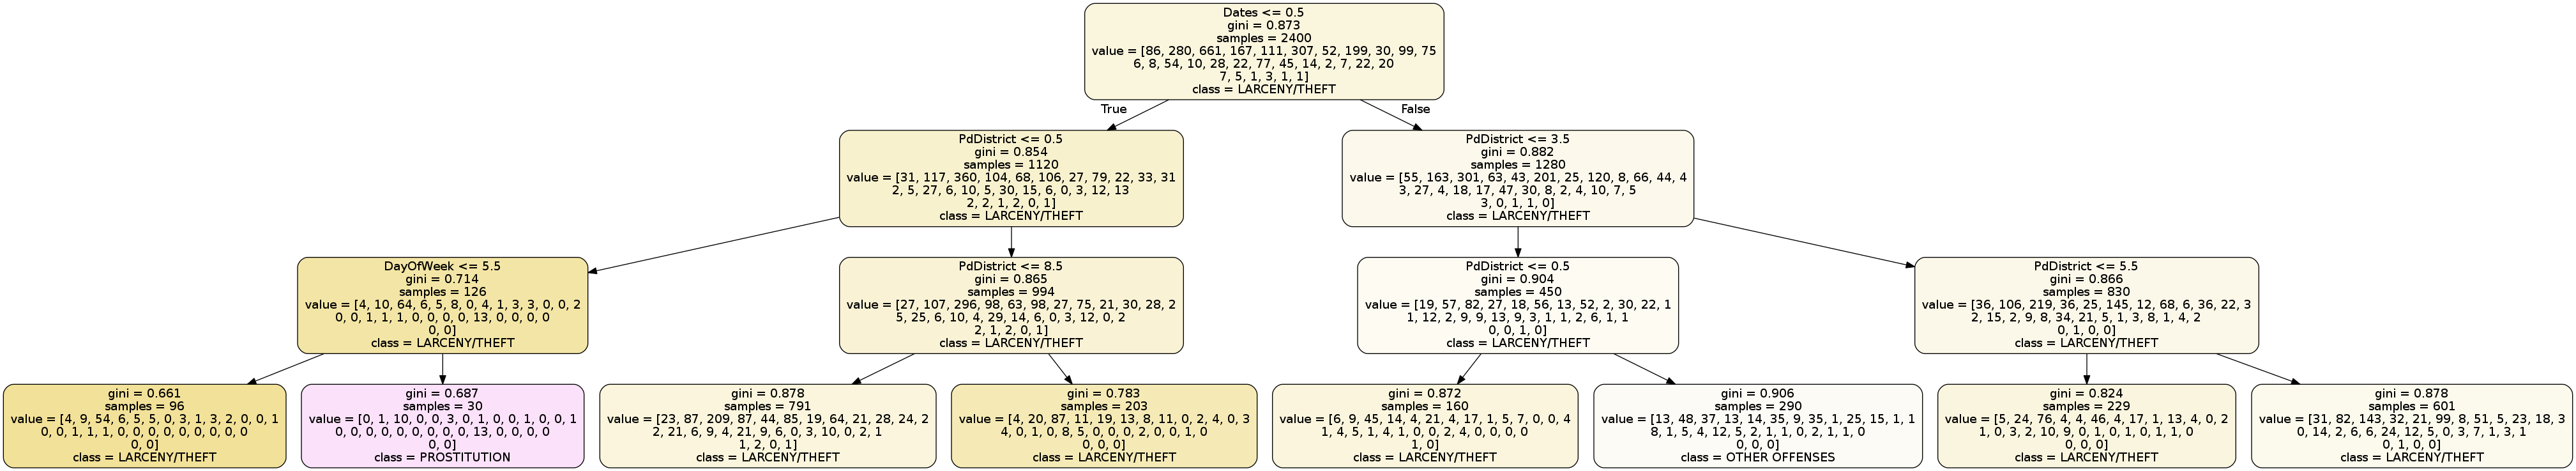

In [8]:
#Hemos elegido un nivel de profundidad igual a 3 porque proporciona un error similar a los árboles de mayor nivel de profundidad
#tras diversas comprobaciones previas como podemos observar.
PImage("tree-gini.png")

In [9]:
#Valores numéricos de los atributos
print(pd.DataFrame(dias_de_la_semana))
print(pd.DataFrame(distritos))
print(pd.DataFrame(momento_dia))
print(pd.DataFrame(categoria ))

   DayOfWeek  Value
0  Wednesday      0
1    Tuesday      1
2     Monday      2
3     Sunday      3
4   Saturday      4
5     Friday      5
6   Thursday      6
   PdDistrict  Value
0    NORTHERN      0
1        PARK      1
2   INGLESIDE      2
3     BAYVIEW      3
4    RICHMOND      4
5     CENTRAL      5
6     TARAVAL      6
7  TENDERLOIN      7
8     MISSION      8
9    SOUTHERN      9
    Dates  Value
0   Tarde      0
1  Mañana      1
2   Noche      2
                       Category  Value
0                      WARRANTS      0
1                OTHER OFFENSES      1
2                 LARCENY/THEFT      2
3                 VEHICLE THEFT      3
4                     VANDALISM      4
5                  NON-CRIMINAL      5
6                       ROBBERY      6
7                       ASSAULT      7
8                   WEAPON LAWS      8
9                      BURGLARY      9
10               SUSPICIOUS OCC     10
11                  DRUNKENNESS     11
12       FORGERY/COUNTERFEITING   

## 4º Seleccionamos 3 reglas que generalizarán lo menos posible: 
Las reglas que generalizan lo menos posible son aquellas que mas especifican, esto es, que tienen más condiciones. Además, 
las reglas que menos generalizan son las que menos muestran cubren, por tanto elegimos las clases con menor número de samples:


Seleccionamos 3 reglas que especializarán lo menos posible:
 - if Dates <= 0.5 and PdDistrict <= 0.5 and DayOfWeek > 5.5  then Category = PROSTITUTION
 - if Dates <= 0.5 and PdDistrict <= 0.5 and DayOfWeek <= 5.5  then Category = LARCENY/THEFT
 - id Dates > 0.5 and PdDistrict <= 3.5 and PdDistrict <= 0.5 then Category = LARCENY/THEFT

Interpretamos las reglas: 
Dates <= 0.5 implica que es entre la mañana y tarde, PdDistrict <= 0.5 implica que ocurre en los distritos NORTHERN y  PARK
y DayofWeef > 5.5 es Jueves. 

## 5º Usamos el clasificador para decidir qué tipos de crímenes ocurrirán la noche del sabado en el distrito de Park. 

In [10]:
#Usamos el clasificador para decidir qué tipos de crímenes ocurrirán un lunes por la mañana en el distrito central. 
tipo_crimen = decision_tree.predict([[2, 5, 1]])
for i in range(len(categoria["Value"])):
    if tipo_crimen[0] == categoria["Value"][i]:
        print("El crimen es del tipo: ", categoria["Category"][i])

El crimen es del tipo:  LARCENY/THEFT
